# 資料前處理

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ldy337","key":"afc5eedb8a179da95ea3e99bb659dc2f"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:36<00:00, 23.0MB/s]
100% 812M/812M [00:36<00:00, 23.3MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

複製圖片到訓練集、驗證集和測試集

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")  ##以圖片"cat.0.jpg"為例，原檔案路徑為/content/train/cat.0.jpg
new_base_dir = pathlib.Path("cats_vs_dogs_small")  ##檔案欲複製到的資料夾名稱

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,  ##src:source-檔案的來源位址; dst:destination-欲將檔案複製到的資料夾的位址
                    dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)  ##將檔案複製到資料夾:cats_vs_dogs_small => train => cat or dog各1000張
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

使用image_dataset_from_directory()來讀取影像

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(  ##以讀取上述train資料夾為例，可得到分成兩類的圖檔共2000張(貓狗各1000張)，且分為32個batch
    new_base_dir / "train",  ##train資料夾中共有2個子資料夾，分別為cat跟dog，以指令"image_dataset_from_directory"讀取檔案後，會自動分為2類
    image_size=(180, 180),  ##圖片像素為180*180，且有R、G、B 3個channel
    batch_size=32)       ##每個batch取32張圖片
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# LeNet

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))  ##LeNet Model
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
       optimizer="rmsprop",
       metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="CNN_for_LeNet_not_freeze",
        save_best_only=True,
      )
]

history_for_LeNet_not_freeze = model.fit(
    train_dataset,  ##train_dataset已包含images及labels,故不須輸入labels資料
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 5s 68ms/step - loss: 65.9526 - accuracy: 0.5485 - val_loss: 0.7519 - val_accuracy: 0.5620
Epoch 2/30
63/63 [==============================] - 5s 74ms/step - loss: 1.8664 - accuracy: 0.5785 - val_loss: 0.9250 - val_accuracy: 0.4990
Epoch 3/30
63/63 [==============================] - 7s 108ms/step - loss: 1.4395 - accuracy: 0.6425 - val_loss: 0.8417 - val_accuracy: 0.5830
Epoch 4/30
63/63 [==============================] - 4s 56ms/step - loss: 1.9270 - accuracy: 0.6840 - val_loss: 0.9737 - val_accuracy: 0.5750
Epoch 5/30
63/63 [==============================] - 5s 81ms/step - loss: 1.2965 - accuracy: 0.7805 - val_loss: 2.2346 - val_accuracy: 0.5280
Epoch 6/30
63/63 [==============================] - 6s 91ms/step - loss: 1.0756 - accuracy: 0.8205 - val_loss: 5.5638 - val_accuracy: 0.5260
Epoch 7/30
63/63 [==============================] - 4s 56ms/step - loss: 0.7966 - accuracy: 0.8555 - val_loss: 1.7871 - val_accuracy: 0.5750
Epoch 8/30


In [ ]:
model = keras.models.load_model("CNN_for_LeNet_not_freeze")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

63/63 [==============================] - 2s 31ms/step - loss: 0.7471 - accuracy: 0.5580
Test acc: 0.558


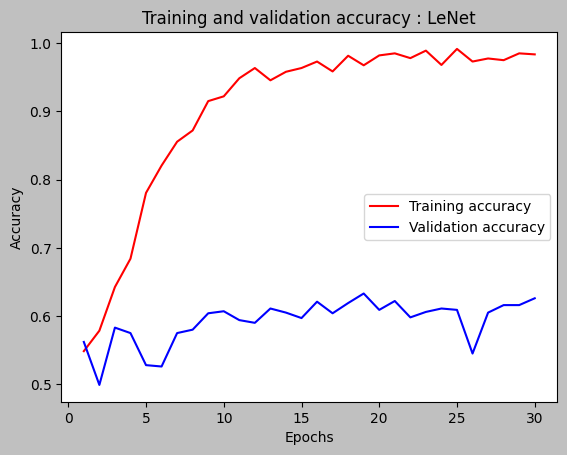

In [4]:
import matplotlib.pyplot as plt

acc = history_for_LeNet_not_freeze.history["accuracy"]
val_acc = history_for_LeNet_not_freeze.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : LeNet")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.5485000014305115, 0.578499972820282, 0.6424999833106995, 0.6840000152587891, 0.7804999947547913, 0.8205000162124634, 0.8554999828338623, 0.871999979019165, 0.9150000214576721, 0.921999990940094, 0.9484999775886536, 0.9635000228881836, 0.9455000162124634, 0.9580000042915344, 0.9635000228881836, 0.9729999899864197, 0.9585000276565552, 0.9815000295639038, 0.9674999713897705, 0.9819999933242798, 0.9850000143051147, 0.9779999852180481, 0.9890000224113464, 0.9679999947547913, 0.9915000200271606, 0.9729999899864197, 0.9775000214576721, 0.9750000238418579, 0.9850000143051147, 0.9835000038146973]
[0.5619999766349792, 0.49900001287460327, 0.5830000042915344, 0.574999988079071, 0.527999997138977, 0.5260000228881836, 0.574999988079071, 0.5799999833106995, 0.6039999723434448, 0.6069999933242798, 0.593999981880188, 0.5899999737739563, 0.6110000014305115, 0.6050000190734863, 0.597000002861023, 0.6209999918937683, 0.6039999723434448, 0.6190000176429749, 0.6330000162124634, 0.609000027179718, 0.6219

# Inception V3(Freeze Conv Base)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# 下載並加載預訓練的 InceptionV3 模型
conv_base = tf.keras.applications.InceptionV3(
    include_top=False,  # 包含頂層全連接層
    weights='imagenet',  # 使用在 ImageNet 上預訓練的權重
)

conv_base.trainable = False


87910968/87910968 [==============================] - 7s 0us/step


In [ ]:
Inputs = keras.Input(shape = (180, 180, 3) )
x = tf.keras.applications.inception_v3.preprocess_input(Inputs)  ##使輸入圖像與模型訓練時使用的圖像具有相同的數據分佈，從而提高預測的準確性和穩定性。
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=Inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
       optimizer="rmsprop",
       metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "CNN_for_Inception_V3_freeze",
        save_best_only=True,
      )
]

history_for_Inception_V3_freeze = model.fit(
    train_dataset,  ##train_dataset已包含images及labels,故不須輸入labels資料
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 59s 834ms/step - loss: 5.5231 - accuracy: 0.9125 - val_loss: 0.4249 - val_accuracy: 0.9800
Epoch 2/30
63/63 [==============================] - 5s 77ms/step - loss: 0.6390 - accuracy: 0.9715 - val_loss: 0.6021 - val_accuracy: 0.9680
Epoch 3/30
63/63 [==============================] - 6s 98ms/step - loss: 0.3682 - accuracy: 0.9815 - val_loss: 1.5129 - val_accuracy: 0.9560
Epoch 4/30
63/63 [==============================] - 5s 78ms/step - loss: 0.3895 - accuracy: 0.9810 - val_loss: 0.5923 - val_accuracy: 0.9770
Epoch 5/30
63/63 [==============================] - 6s 96ms/step - loss: 0.1166 - accuracy: 0.9945 - val_loss: 0.5374 - val_accuracy: 0.9760
Epoch 6/30
63/63 [==============================] - 6s 92ms/step - loss: 0.0465 - accuracy: 0.9985 - val_loss: 0.8435 - val_accuracy: 0.9710
Epoch 7/30
63/63 [==============================] - 9s 138ms/step - loss: 0.2066 - accuracy: 0.9930 - val_loss: 0.4594 - val_accuracy: 0.9810
Epoch 8/30

In [ ]:
model = keras.models.load_model("CNN_for_Inception_V3_freeze")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

63/63 [==============================] - 5s 50ms/step - loss: 0.3385 - accuracy: 0.9790
Test acc: 0.979


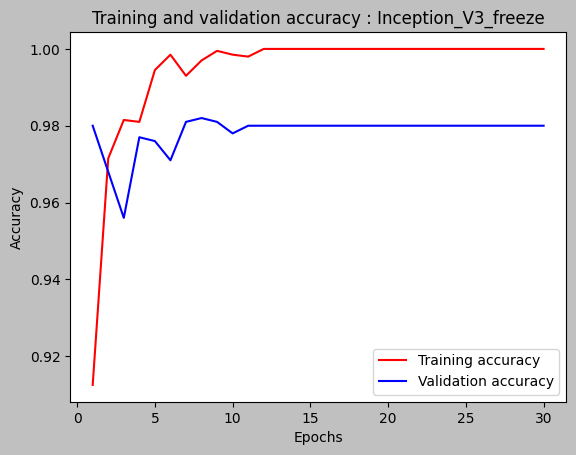

In [ ]:
import matplotlib.pyplot as plt

acc = history_for_Inception_V3_freeze.history["accuracy"]
val_acc = history_for_Inception_V3_freeze.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : Inception_V3_freeze")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.9125000238418579, 0.9714999794960022, 0.9815000295639038, 0.9810000061988831, 0.9944999814033508, 0.9984999895095825, 0.9929999709129333, 0.996999979019165, 0.9994999766349792, 0.9984999895095825, 0.9980000257492065, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9800000190734863, 0.9679999947547913, 0.9559999704360962, 0.9769999980926514, 0.9760000109672546, 0.9710000157356262, 0.9810000061988831, 0.9819999933242798, 0.9810000061988831, 0.9779999852180481, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863]


# Inception V3(Not Freeze Conv Base)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# 下載並加載預訓練的 InceptionV3 模型
conv_base = tf.keras.applications.InceptionV3(
    include_top=False,  # 包含頂層全連接層
    weights='imagenet',  # 使用在 ImageNet 上預訓練的權重
)

conv_base.trainable = True


In [ ]:
Inputs = keras.Input(shape = (180, 180, 3) )
x = tf.keras.applications.inception_v3.preprocess_input(Inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=Inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
       optimizer="rmsprop",
       metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "CNN_for_Inception_V3_not_freeze",
        save_best_only=True,
      )
]

history_for_Inception_V3_not_freeze = model.fit(
    train_dataset,  ##train_dataset已包含images及labels,故不須輸入labels資料
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 80s 853ms/step - loss: 2.0798 - accuracy: 0.5265 - val_loss: 0.6922 - val_accuracy: 0.5620
Epoch 2/30
63/63 [==============================] - 13s 199ms/step - loss: 0.6853 - accuracy: 0.5735 - val_loss: 1.6712 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 13s 193ms/step - loss: 0.4924 - accuracy: 0.7830 - val_loss: 215.2451 - val_accuracy: 0.5160
Epoch 4/30
63/63 [==============================] - 13s 200ms/step - loss: 0.3585 - accuracy: 0.8595 - val_loss: 15.5109 - val_accuracy: 0.7170
Epoch 5/30
63/63 [==============================] - 13s 205ms/step - loss: 0.2409 - accuracy: 0.9030 - val_loss: 351.9026 - val_accuracy: 0.5340
Epoch 6/30
63/63 [==============================] - 12s 195ms/step - loss: 0.1830 - accuracy: 0.9305 - val_loss: 5.5048 - val_accuracy: 0.7710
Epoch 7/30
63/63 [==============================] - 49s 773ms/step - loss: 0.1297 - accuracy: 0.9495 - val_loss: 0.6242 - val_accuracy: 0

In [ ]:
model = keras.models.load_model("CNN_for_Inception_V3_not_freeze")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

63/63 [==============================] - 7s 81ms/step - loss: 0.3287 - accuracy: 0.9145
Test acc: 0.914


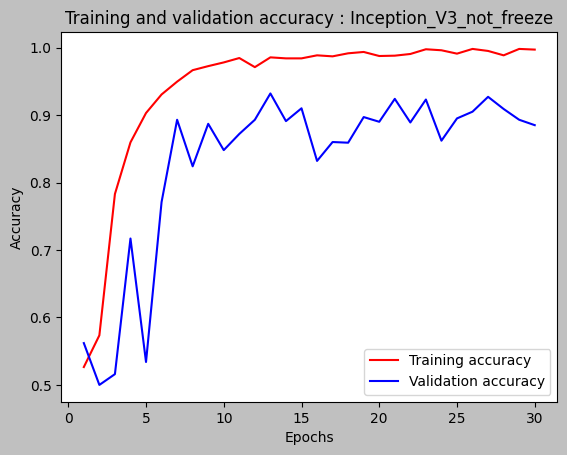

In [ ]:
import matplotlib.pyplot as plt

acc = history_for_Inception_V3_not_freeze.history["accuracy"]
val_acc = history_for_Inception_V3_not_freeze.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : Inception_V3_not_freeze")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.5264999866485596, 0.5734999775886536, 0.7829999923706055, 0.859499990940094, 0.902999997138977, 0.9304999709129333, 0.9495000243186951, 0.9664999842643738, 0.9725000262260437, 0.9779999852180481, 0.984499990940094, 0.9710000157356262, 0.9854999780654907, 0.984000027179718, 0.984000027179718, 0.9884999990463257, 0.9869999885559082, 0.9915000200271606, 0.9934999942779541, 0.987500011920929, 0.9879999756813049, 0.9904999732971191, 0.9975000023841858, 0.9959999918937683, 0.9909999966621399, 0.9980000257492065, 0.9950000047683716, 0.9884999990463257, 0.9980000257492065, 0.996999979019165]
[0.5619999766349792, 0.5, 0.515999972820282, 0.7170000076293945, 0.5339999794960022, 0.7710000276565552, 0.8930000066757202, 0.8240000009536743, 0.8870000243186951, 0.8479999899864197, 0.871999979019165, 0.8930000066757202, 0.9319999814033508, 0.890999972820282, 0.9100000262260437, 0.8320000171661377, 0.8600000143051147, 0.859000027179718, 0.8970000147819519, 0.8899999856948853, 0.9240000247955322, 0.88

# 繪製折線圖 - Inception V3(Freeze vs Not Freeze)

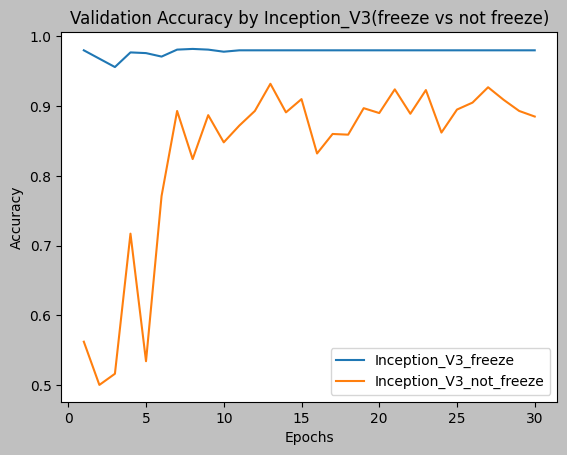

In [ ]:
import matplotlib.pyplot as plt

val_acc_Inception_V3_freeze = history_for_Inception_V3_freeze.history["val_accuracy"]
val_acc_Inception_V3_not_freeze = history_for_Inception_V3_not_freeze.history["val_accuracy"]

epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, val_acc_Inception_V3_freeze, label="Inception_V3_freeze")
plt.plot(epochs, val_acc_Inception_V3_not_freeze,  label="Inception_V3_not_freeze")

plt.title("Validation Accuracy by Inception_V3(freeze vs not freeze)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# VGG16(Freeze Conv Base)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",  ##指定用於初始化模型的權重(本例是使用以ImageNet訓練好的參數)
    include_top=False,  ##代表要不要包含VGG16頂部的密集連接分類器
    input_shape=(180, 180, 3))  ##提供給神經網路的影像張量的shape，如果不傳遞此參數，則神經網路將能夠處理任何shape的輸入張量

conv_base.trainable = False  ##凍結可訓練參數

In [ ]:
inputs = keras.Input(shape = (180, 180, 3) )
tf.keras.applications.vgg16.preprocess_input(inputs)  ##使輸入圖像與模型訓練時使用的圖像具有相同的數據分佈，從而提高預測的準確性和穩定性。
x = conv_base(Inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=Inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
       optimizer="rmsprop",
       metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="CNN_for_VGG16_freeze",
        save_best_only=True,
      )
]

history_for_VGG16_freeze = model.fit(
    train_dataset,  ##train_dataset已包含images及labels,故不須輸入labels資料
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 13s 195ms/step - loss: 8.2873 - accuracy: 0.8900 - val_loss: 0.8269 - val_accuracy: 0.9290
Epoch 2/30
63/63 [==============================] - 11s 178ms/step - loss: 0.3445 - accuracy: 0.9685 - val_loss: 0.5591 - val_accuracy: 0.9450
Epoch 3/30
63/63 [==============================] - 11s 176ms/step - loss: 0.2141 - accuracy: 0.9840 - val_loss: 0.7322 - val_accuracy: 0.9390
Epoch 4/30
63/63 [==============================] - 9s 143ms/step - loss: 0.0900 - accuracy: 0.9880 - val_loss: 0.6943 - val_accuracy: 0.9530
Epoch 5/30
63/63 [==============================] - 11s 175ms/step - loss: 0.0587 - accuracy: 0.9915 - val_loss: 0.8607 - val_accuracy: 0.9410
Epoch 6/30
63/63 [==============================] - 10s 147ms/step - loss: 0.0389 - accuracy: 0.9945 - val_loss: 0.8887 - val_accuracy: 0.9450
Epoch 7/30
63/63 [==============================] - 11s 174ms/step - loss: 0.0837 - accuracy: 0.9945 - val_loss: 0.8503 - val_accuracy: 0.9420


In [ ]:
model = keras.models.load_model("CNN_for_VGG16_freeze")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

63/63 [==============================] - 7s 92ms/step - loss: 0.5448 - accuracy: 0.9515
Test acc: 0.951


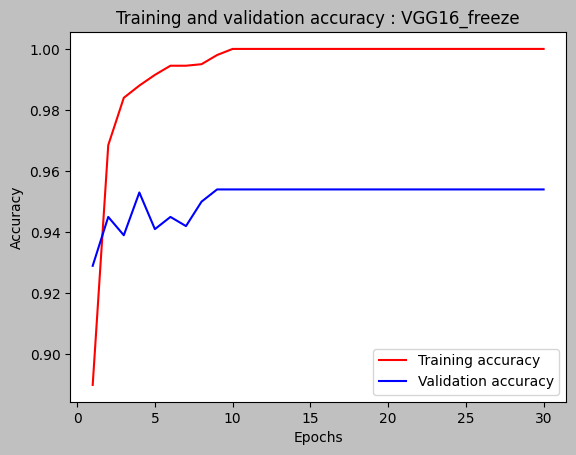

In [ ]:
import matplotlib.pyplot as plt

acc = history_for_VGG16_freeze.history["accuracy"]
val_acc = history_for_VGG16_freeze.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : VGG16_freeze")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.8899999856948853, 0.968500018119812, 0.984000027179718, 0.9879999756813049, 0.9915000200271606, 0.9944999814033508, 0.9944999814033508, 0.9950000047683716, 0.9980000257492065, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9290000200271606, 0.9449999928474426, 0.9390000104904175, 0.953000009059906, 0.9409999847412109, 0.9449999928474426, 0.9419999718666077, 0.949999988079071, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027]


# VGG16(Not Freeze Conv Base)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",  ##指定用於初始化模型的權重(本例是使用以ImageNet訓練好的參數)
    include_top=False,  ##代表要不要包含VGG16頂部的密集連接分類器
    input_shape=(180, 180, 3))  ##提供給神經網路的影像張量的shape，如果不傳遞此參數，則神經網路將能夠處理任何shape的輸入張量

conv_base.trainable = True  ##凍結可訓練參數

In [ ]:
inputs = keras.Input(shape = (180, 180, 3) )
tf.keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(Inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=Inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
       optimizer="rmsprop",
       metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="CNN_for_VGG16_not_freeze",
        save_best_only=True,
      )
]

history_for_VGG16_not_freeze = model.fit(
    train_dataset,  ##train_dataset已包含images及labels,故不須輸入labels資料
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 28s 375ms/step - loss: 6674.6079 - accuracy: 0.5335 - val_loss: 0.6803 - val_accuracy: 0.5980
Epoch 2/30
63/63 [==============================] - 21s 330ms/step - loss: 0.8486 - accuracy: 0.5095 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 20s 319ms/step - loss: 0.6931 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 21s 322ms/step - loss: 2.9455 - accuracy: 0.5175 - val_loss: 0.7296 - val_accuracy: 0.5000
Epoch 5/30
63/63 [==============================] - 21s 330ms/step - loss: 0.7658 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/30
63/63 [==============================] - 21s 329ms/step - loss: 1.4251 - accuracy: 0.5155 - val_loss: 0.6984 - val_accuracy: 0.5000
Epoch 7/30
63/63 [==============================] - 21s 322ms/step - loss: 1.0800 - accuracy: 0.4890 - val_loss: 0.6930 - val_accuracy: 0.5

In [ ]:
model = keras.models.load_model("CNN_for_VGG16_not_freeze")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

63/63 [==============================] - 6s 88ms/step - loss: 0.6008 - accuracy: 0.7105
Test acc: 0.711


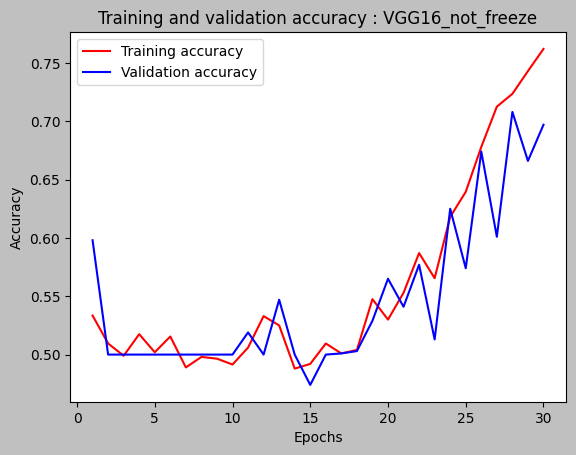

In [ ]:
import matplotlib.pyplot as plt

acc = history_for_VGG16_not_freeze.history["accuracy"]
val_acc = history_for_VGG16_not_freeze.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : VGG16_not_freeze")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.5335000157356262, 0.5095000267028809, 0.49900001287460327, 0.5174999833106995, 0.5019999742507935, 0.515500009059906, 0.48899999260902405, 0.49799999594688416, 0.4964999854564667, 0.49149999022483826, 0.5059999823570251, 0.5329999923706055, 0.5249999761581421, 0.4880000054836273, 0.492000013589859, 0.5095000267028809, 0.5009999871253967, 0.5040000081062317, 0.5475000143051147, 0.5299999713897705, 0.5529999732971191, 0.5870000123977661, 0.565500020980835, 0.6179999709129333, 0.6395000219345093, 0.6779999732971191, 0.7124999761581421, 0.7235000133514404, 0.7429999709129333, 0.7620000243186951]
[0.5979999899864197, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5189999938011169, 0.5, 0.546999990940094, 0.5, 0.4740000069141388, 0.5, 0.5009999871253967, 0.503000020980835, 0.5289999842643738, 0.5649999976158142, 0.5410000085830688, 0.5770000219345093, 0.5130000114440918, 0.625, 0.5740000009536743, 0.6740000247955322, 0.6010000109672546, 0.7080000042915344, 0.6660000085830688, 0.6970000267

# 繪製折線圖 - Inception VGG16(Freeze vs Not Freeze)

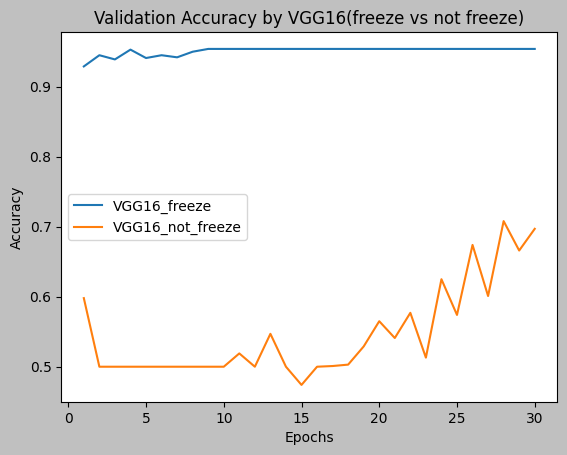

In [ ]:
import matplotlib.pyplot as plt

val_acc_VGG16_freeze = history_for_VGG16_freeze.history["val_accuracy"]
val_acc_VGG16_not_freeze = history_for_VGG16_not_freeze.history["val_accuracy"]

epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, val_acc_VGG16_freeze, label="VGG16_freeze")
plt.plot(epochs, val_acc_VGG16_not_freeze,  label="VGG16_not_freeze")

plt.title("Validation Accuracy by VGG16(freeze vs not freeze)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# ResNet50(Freeze_Conv_Base)

In [ ]:
conv_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(180,180,3))

conv_model.trainable = False  ##凍結可訓練參數

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
inputs = keras.Input(shape = (180, 180, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = conv_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
       optimizer="rmsprop",
       metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="CNN_for_ResNet50_freeze",
        save_best_only=True,
      )
]

history_for_ResNet50_freeze = model.fit(
    train_dataset,  ##train_dataset已包含images及labels,故不須輸入labels資料
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 36s 475ms/step - loss: 0.7905 - accuracy: 0.8870 - val_loss: 0.1139 - val_accuracy: 0.9560
Epoch 2/30
63/63 [==============================] - 7s 107ms/step - loss: 0.1780 - accuracy: 0.9500 - val_loss: 0.1940 - val_accuracy: 0.9450
Epoch 3/30
63/63 [==============================] - 8s 121ms/step - loss: 0.1339 - accuracy: 0.9615 - val_loss: 0.4804 - val_accuracy: 0.8930
Epoch 4/30
63/63 [==============================] - 7s 110ms/step - loss: 0.1471 - accuracy: 0.9575 - val_loss: 0.3268 - val_accuracy: 0.9140
Epoch 5/30
63/63 [==============================] - 7s 109ms/step - loss: 0.0893 - accuracy: 0.9755 - val_loss: 0.1590 - val_accuracy: 0.9650
Epoch 6/30
63/63 [==============================] - 10s 158ms/step - loss: 0.0939 - accuracy: 0.9730 - val_loss: 0.2640 - val_accuracy: 0.9410
Epoch 7/30
63/63 [==============================] - 7s 106ms/step - loss: 0.0797 - accuracy: 0.9770 - val_loss: 0.2559 - val_accuracy: 0.9550
Epoc

In [ ]:
model = keras.models.load_model("CNN_for_ResNet50_freeze")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

63/63 [==============================] - 6s 72ms/step - loss: 0.1128 - accuracy: 0.9590
Test acc: 0.959


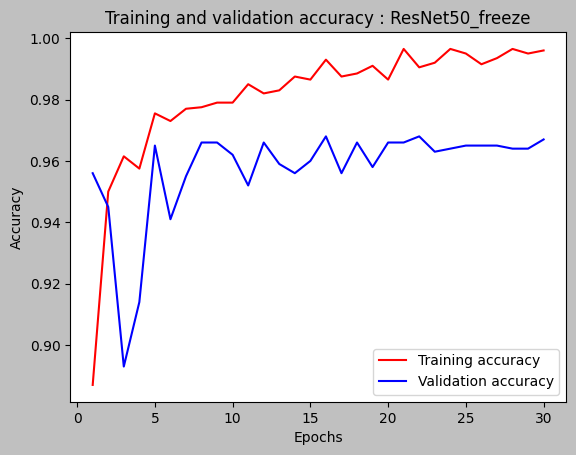

In [ ]:
import matplotlib.pyplot as plt

acc = history_for_ResNet50_freeze.history["accuracy"]
val_acc = history_for_ResNet50_freeze.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : ResNet50_freeze")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.8870000243186951, 0.949999988079071, 0.9614999890327454, 0.9574999809265137, 0.9754999876022339, 0.9729999899864197, 0.9769999980926514, 0.9775000214576721, 0.9789999723434448, 0.9789999723434448, 0.9850000143051147, 0.9819999933242798, 0.9829999804496765, 0.987500011920929, 0.9865000247955322, 0.9929999709129333, 0.987500011920929, 0.9884999990463257, 0.9909999966621399, 0.9865000247955322, 0.9965000152587891, 0.9904999732971191, 0.9919999837875366, 0.9965000152587891, 0.9950000047683716, 0.9915000200271606, 0.9934999942779541, 0.9965000152587891, 0.9950000047683716, 0.9959999918937683]
[0.9559999704360962, 0.9449999928474426, 0.8930000066757202, 0.9139999747276306, 0.9649999737739563, 0.9409999847412109, 0.9549999833106995, 0.9660000205039978, 0.9660000205039978, 0.9620000123977661, 0.9520000219345093, 0.9660000205039978, 0.9589999914169312, 0.9559999704360962, 0.9599999785423279, 0.9679999947547913, 0.9559999704360962, 0.9660000205039978, 0.9580000042915344, 0.9660000205039978, 0

# ResNet50(Not Freeze Conv Base)

In [ ]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(180,180,3))

base_model.trainable = True  ##凍結可訓練參數

In [ ]:
inputs = keras.Input(shape = (180, 180, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# 創建完整的模型
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
       optimizer="rmsprop",
       metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="CNN_for_ResNet50_not_freeze",
        save_best_only=True,
      )
]

history_for_ResNet50_not_freeze = model.fit(
    train_dataset,  ##train_dataset已包含images及labels,故不須輸入labels資料
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 69s 719ms/step - loss: 1.0730 - accuracy: 0.6385 - val_loss: 179.2431 - val_accuracy: 0.5030
Epoch 2/30
63/63 [==============================] - 17s 272ms/step - loss: 0.5468 - accuracy: 0.7495 - val_loss: 339.6009 - val_accuracy: 0.5080
Epoch 3/30
63/63 [==============================] - 18s 280ms/step - loss: 0.3380 - accuracy: 0.8605 - val_loss: 280.1254 - val_accuracy: 0.5020
Epoch 4/30
63/63 [==============================] - 46s 739ms/step - loss: 0.2154 - accuracy: 0.9120 - val_loss: 1.9565 - val_accuracy: 0.7760
Epoch 5/30
63/63 [==============================] - 17s 271ms/step - loss: 0.1875 - accuracy: 0.9315 - val_loss: 2.0126 - val_accuracy: 0.8410
Epoch 6/30
63/63 [==============================] - 18s 279ms/step - loss: 0.1253 - accuracy: 0.9565 - val_loss: 2.6371 - val_accuracy: 0.7160
Epoch 7/30
63/63 [==============================] - 46s 733ms/step - loss: 0.1153 - accuracy: 0.9585 - val_loss: 1.3373 - val_accuracy: 

In [ ]:
model = keras.models.load_model("CNN_for_ResNet50_not_freeze")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

63/63 [==============================] - 6s 68ms/step - loss: 0.5692 - accuracy: 0.8900
Test acc: 0.890


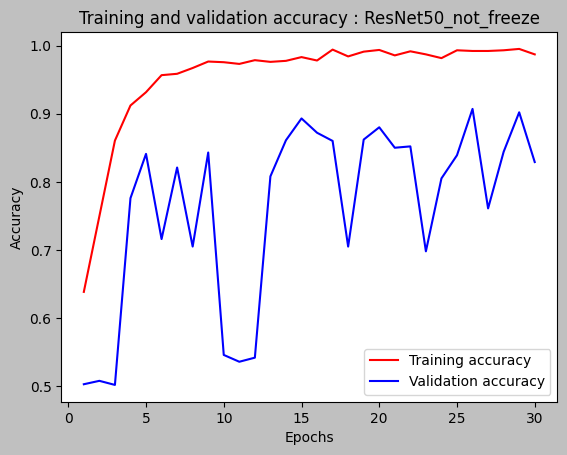

In [ ]:
import matplotlib.pyplot as plt

acc = history_for_ResNet50_not_freeze.history["accuracy"]
val_acc = history_for_ResNet50_not_freeze.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : ResNet50_not_freeze")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.6384999752044678, 0.7494999766349792, 0.8604999780654907, 0.9120000004768372, 0.9315000176429749, 0.9564999938011169, 0.9585000276565552, 0.9670000076293945, 0.9764999747276306, 0.9754999876022339, 0.9729999899864197, 0.9785000085830688, 0.9760000109672546, 0.9775000214576721, 0.9829999804496765, 0.9779999852180481, 0.9940000176429749, 0.984000027179718, 0.9909999966621399, 0.9934999942779541, 0.9854999780654907, 0.9915000200271606, 0.9869999885559082, 0.9815000295639038, 0.9929999709129333, 0.9919999837875366, 0.9919999837875366, 0.9929999709129333, 0.9950000047683716, 0.9869999885559082]
[0.503000020980835, 0.5080000162124634, 0.5019999742507935, 0.7760000228881836, 0.8410000205039978, 0.7160000205039978, 0.8209999799728394, 0.7049999833106995, 0.8429999947547913, 0.5460000038146973, 0.5360000133514404, 0.5419999957084656, 0.8080000281333923, 0.8610000014305115, 0.8930000066757202, 0.871999979019165, 0.8600000143051147, 0.7049999833106995, 0.8619999885559082, 0.8799999952316284, 0

# 繪製折線圖 - ResNet50(Freeze vs Not Freeze)

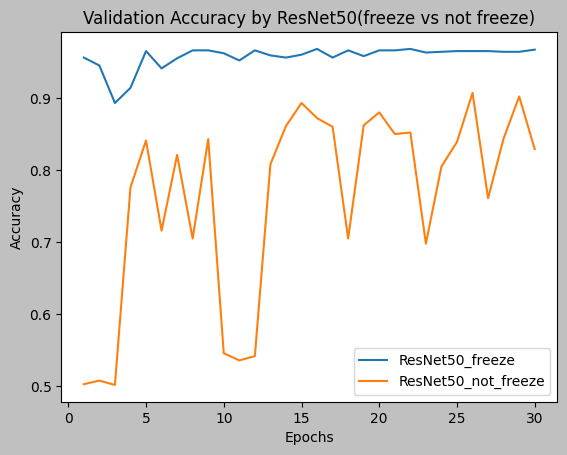

In [ ]:
import matplotlib.pyplot as plt

val_acc_ResNet50_freeze = history_for_ResNet50_freeze.history["val_accuracy"]
val_acc_ResNet50_not_freeze = history_for_ResNet50_not_freeze.history["val_accuracy"]

epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, val_acc_ResNet50_freeze, label="ResNet50_freeze")
plt.plot(epochs, val_acc_ResNet50_not_freeze,  label="ResNet50_not_freeze")

plt.title("Validation Accuracy by ResNet50(freeze vs not freeze)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 繪製折線圖 - Inception V3, VGG16, ResNet50(Freeze Conv Base)

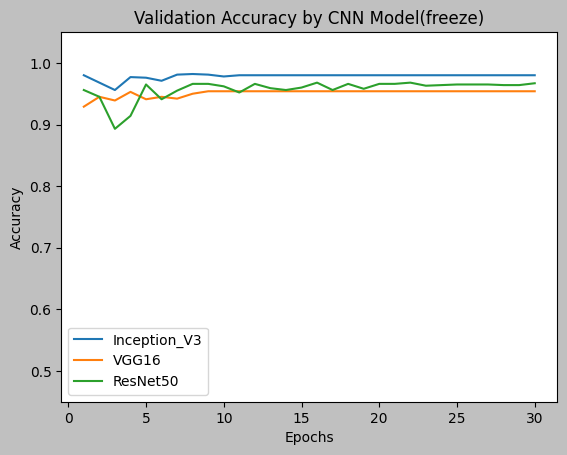

In [28]:
import matplotlib.pyplot as plt

#val_acc_Inception_V3_freeze = history_for_Inception_V3_freeze.history["val_accuracy"]
#val_acc_VGG16_freeze = history_for_VGG16_freeze.history["val_accuracy"]
#val_acc_ResNet50_freeze = history_for_ResNet50_freeze.history["val_accuracy"]

epochs = range(1, 30 + 1)
plt.gcf().set_facecolor('silver')
plt.ylim(0.45, 1.05)
plt.yticks([0.5,0.6,0.7,0.8,0.9, 1.0])
plt.plot(epochs, val_acc_Inception_V3_freeze,  label="Inception_V3")
plt.plot(epochs, val_acc_VGG16_freeze,  label="VGG16")
plt.plot(epochs, val_acc_ResNet50_freeze,  label="ResNet50")

plt.title("Validation Accuracy by CNN Model(freeze)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#繪製折線圖 - LeNet, Inception V3, VGG16, ResNet50(Not Freeze Conv Base)

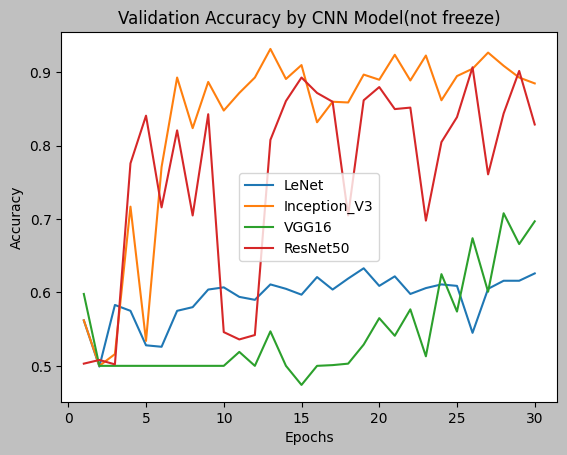

In [ ]:
import matplotlib.pyplot as plt

val_acc_LeNet_not_freeze = history_for_LeNet_not_freeze.history["val_accuracy"]
val_acc_Inception_V3_not_freeze = history_for_Inception_V3_not_freeze.history["val_accuracy"]
val_acc_VGG16_not_freeze = history_for_VGG16_not_freeze.history["val_accuracy"]
val_acc_ResNet50_not_freeze = history_for_ResNet50_not_freeze.history["val_accuracy"]

epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, val_acc_LeNet_not_freeze, label="LeNet")
plt.plot(epochs, val_acc_Inception_V3_not_freeze,  label="Inception_V3")
plt.plot(epochs, val_acc_VGG16_not_freeze,  label="VGG16")
plt.plot(epochs, val_acc_ResNet50_not_freeze,  label="ResNet50")

plt.title("Validation Accuracy by CNN Model(not freeze)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Data Augmentation - LeNet

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),  ##隨機將50%的輸入影像進行水平翻轉
        layers.RandomRotation(0.1),  ##旋轉輸入影像，角度為[-10%,+10%]範圍內的一個隨機值(以角度為單位則為[-36度,+36度])
        layers.RandomZoom(0.2),  ##放大或縮小影像，幅度為[-20%,+20%]內的一個隨機百分比
        layers.RandomContrast(0.2),  ##隨機調整對比度 [0.8, 1.2]
        layers.RandomBrightness(0.2),  ##隨機調整亮度 [0.8, 1.2]
    ]
)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(180, 180, 3))  ##LeNet Model
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
       optimizer="rmsprop",
       metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="CNN_for_LeNet_Augmentation",
        save_best_only=True,
      )
]

history_for_LeNet_Augmentation = model.fit(
    train_dataset,  ##train_dataset已包含images及labels,故不須輸入labels資料
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 6s 72ms/step - loss: 43.3204 - accuracy: 0.5675 - val_loss: 0.6670 - val_accuracy: 0.5760
Epoch 2/30
63/63 [==============================] - 7s 100ms/step - loss: 2.6971 - accuracy: 0.5975 - val_loss: 3.0119 - val_accuracy: 0.5010
Epoch 3/30
63/63 [==============================] - 4s 57ms/step - loss: 1.7602 - accuracy: 0.6680 - val_loss: 0.7954 - val_accuracy: 0.5670
Epoch 4/30
63/63 [==============================] - 4s 57ms/step - loss: 1.5312 - accuracy: 0.7510 - val_loss: 1.4270 - val_accuracy: 0.5460
Epoch 5/30
63/63 [==============================] - 6s 96ms/step - loss: 0.9547 - accuracy: 0.7770 - val_loss: 1.2182 - val_accuracy: 0.6120
Epoch 6/30
63/63 [==============================] - 4s 57ms/step - loss: 0.3600 - accuracy: 0.8600 - val_loss: 1.5179 - val_accuracy: 0.5900
Epoch 7/30
63/63 [==============================] - 4s 60ms/step - loss: 1.5471 - accuracy: 0.8925 - val_loss: 3.7303 - val_accuracy: 0.5430
Epoch 8/30


In [ ]:
model = keras.models.load_model("CNN_for_LeNet_Augmentation")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

63/63 [==============================] - 3s 34ms/step - loss: 0.6607 - accuracy: 0.5995
Test acc: 0.600


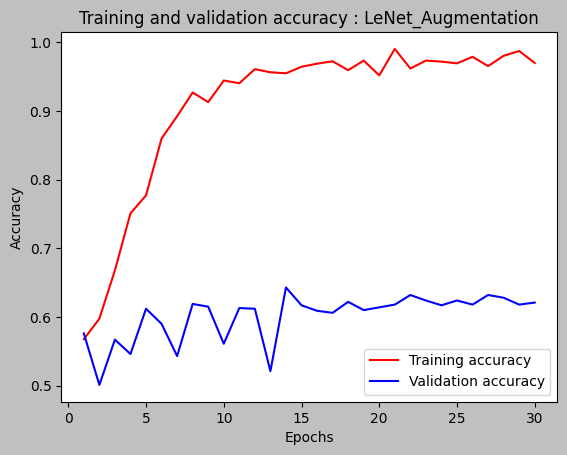

In [ ]:
import matplotlib.pyplot as plt

acc = history_for_LeNet_Augmentation.history["accuracy"]
val_acc = history_for_LeNet_Augmentation.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : LeNet_Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.5674999952316284, 0.5975000262260437, 0.6679999828338623, 0.7509999871253967, 0.7770000100135803, 0.8600000143051147, 0.8924999833106995, 0.9269999861717224, 0.9129999876022339, 0.9445000290870667, 0.940500020980835, 0.9610000252723694, 0.9564999938011169, 0.9549999833106995, 0.9645000100135803, 0.968999981880188, 0.9725000262260437, 0.9595000147819519, 0.9735000133514404, 0.9520000219345093, 0.9904999732971191, 0.9620000123977661, 0.9735000133514404, 0.972000002861023, 0.9695000052452087, 0.9789999723434448, 0.965499997138977, 0.9804999828338623, 0.987500011920929, 0.9700000286102295]
[0.5759999752044678, 0.5009999871253967, 0.5669999718666077, 0.5460000038146973, 0.6119999885559082, 0.5899999737739563, 0.5429999828338623, 0.6190000176429749, 0.6150000095367432, 0.5609999895095825, 0.6129999756813049, 0.6119999885559082, 0.5210000276565552, 0.6430000066757202, 0.6169999837875366, 0.609000027179718, 0.6060000061988831, 0.621999979019165, 0.6100000143051147, 0.6140000224113464, 0.617

# 繪製折線圖 - Data augmentation

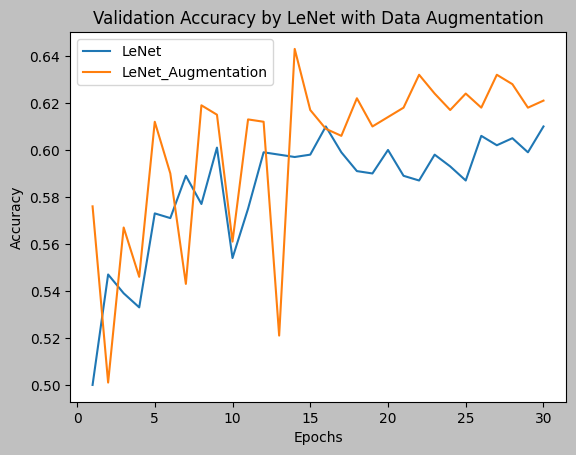

In [ ]:
import matplotlib.pyplot as plt

val_acc_LeNet = history_for_LeNet.history["val_accuracy"]
val_acc_LeNet_Augmentation = history_for_LeNet_Augmentation.history["val_accuracy"]

epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, val_acc_LeNet, label="LeNet")
plt.plot(epochs, val_acc_LeNet_Augmentation,  label="LeNet_Augmentation")

plt.title("Validation Accuracy by LeNet with Data Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Feature Extraction - VGG16(特徵萃取)

將原始影像輸入捲積基底後，得到特徵萃取出的features及labels，以此來訓練分類器(僅訓練分類器，無訓練捲積基底)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",  ##指定用於初始化模型的權重(本例是使用以ImageNet訓練好的參數)
    include_top=False,  ##代表要不要包含VGG16頂部的密集連接分類器
    input_shape=(180, 180, 3))  ##提供給神經網路的影像張量的shape，如果不傳遞此參數，則神經網路將能夠處理任何shape的輸入張量

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
import numpy as np

def extract_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_extract_features, train_labels = extract_features_and_labels(train_dataset)
val_extract_features, val_labels = extract_features_and_labels(validation_dataset)
test_extract_features, test_labels = extract_features_and_labels(test_dataset)

1/1 [==============================] - 0s 26ms/step


In [ ]:
train_extract_features.shape

(2000, 5, 5, 512)

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)  ##將特徵圖傳入Dense(密集層)前，要先使用平坦層(Flatten)將其扁平化
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="CNN_for_VGG16_feature_extraction",
      save_best_only=True,
      monitor="val_loss")
]

history_for_VGG16_feature_extraction = model.fit(
    train_extract_features, train_labels,  ##因為資料進行過函數"extract_features_and_labels"的特徵萃取，故需輸入images及labels
    epochs=30,
    validation_data=(val_extract_features, val_labels),
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 3s 36ms/step - loss: 14.4293 - accuracy: 0.9265 - val_loss: 2.4270 - val_accuracy: 0.9770
Epoch 2/30
63/63 [==============================] - 1s 9ms/step - loss: 4.6817 - accuracy: 0.9735 - val_loss: 3.8463 - val_accuracy: 0.9660
Epoch 3/30
63/63 [==============================] - 1s 8ms/step - loss: 1.3957 - accuracy: 0.9850 - val_loss: 4.7254 - val_accuracy: 0.9700
Epoch 4/30
63/63 [==============================] - 1s 9ms/step - loss: 1.0622 - accuracy: 0.9915 - val_loss: 5.9554 - val_accuracy: 0.9650
Epoch 5/30
63/63 [==============================] - 1s 9ms/step - loss: 1.4680 - accuracy: 0.9865 - val_loss: 6.3619 - val_accuracy: 0.9720
Epoch 6/30
63/63 [==============================] - 1s 8ms/step - loss: 0.6996 - accuracy: 0.9950 - val_loss: 4.3678 - val_accuracy: 0.9740
Epoch 7/30
63/63 [==============================] - 1s 15ms/step - loss: 0.2503 - accuracy: 0.9970 - val_loss: 6.6984 - val_accuracy: 0.9690
Epoch 8/30
63/63 

In [ ]:
model = keras.models.load_model("CNN_for_VGG16_feature_extraction")
print(f"Test acc: {model.evaluate(test_extract_features, test_labels)[1]:.3f}")

63/63 [==============================] - 1s 10ms/step - loss: 3.6967 - accuracy: 0.9715
Test acc: 0.971


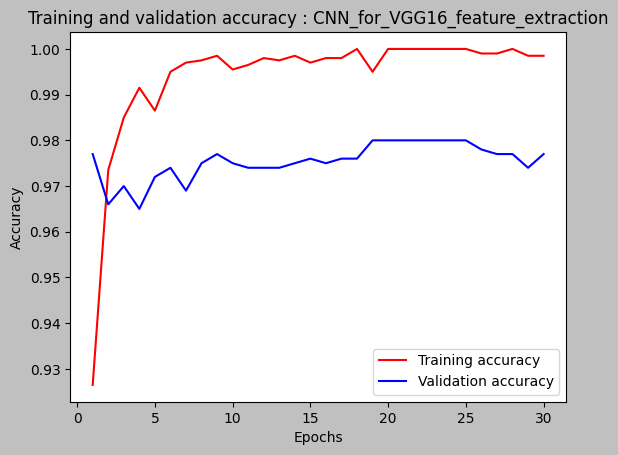

In [ ]:
import matplotlib.pyplot as plt

acc = history_for_VGG16_feature_extraction.history["accuracy"]
val_acc = history_for_VGG16_feature_extraction.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : CNN_for_VGG16_feature_extraction")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.9265000224113464, 0.9735000133514404, 0.9850000143051147, 0.9915000200271606, 0.9865000247955322, 0.9950000047683716, 0.996999979019165, 0.9975000023841858, 0.9984999895095825, 0.9955000281333923, 0.9965000152587891, 0.9980000257492065, 0.9975000023841858, 0.9984999895095825, 0.996999979019165, 0.9980000257492065, 0.9980000257492065, 1.0, 0.9950000047683716, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990000128746033, 0.9990000128746033, 1.0, 0.9984999895095825, 0.9984999895095825]
[0.9769999980926514, 0.9660000205039978, 0.9700000286102295, 0.9649999737739563, 0.972000002861023, 0.9739999771118164, 0.968999981880188, 0.9750000238418579, 0.9769999980926514, 0.9750000238418579, 0.9739999771118164, 0.9739999771118164, 0.9739999771118164, 0.9750000238418579, 0.9760000109672546, 0.9750000238418579, 0.9760000109672546, 0.9760000109672546, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9779999852180481, 0.

# Feature Extraction - VGG16(凍結conv_base)

使用之前已訓練完成的結果(VGG16 freeze Conv Base)

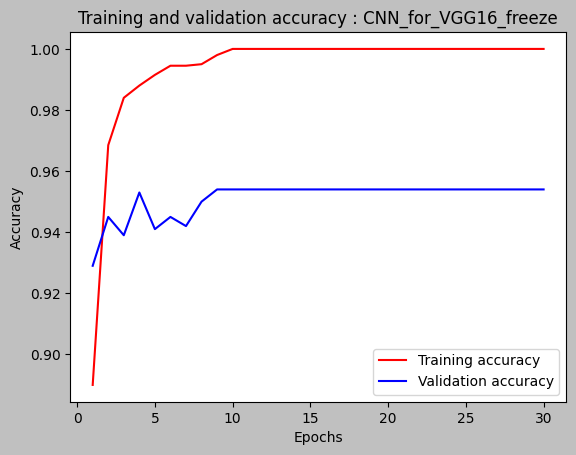

In [ ]:
import matplotlib.pyplot as plt

acc = history_for_VGG16_freeze.history["accuracy"]
val_acc = history_for_VGG16_freeze.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : CNN_for_VGG16_freeze")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.8899999856948853, 0.968500018119812, 0.984000027179718, 0.9879999756813049, 0.9915000200271606, 0.9944999814033508, 0.9944999814033508, 0.9950000047683716, 0.9980000257492065, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9290000200271606, 0.9449999928474426, 0.9390000104904175, 0.953000009059906, 0.9409999847412109, 0.9449999928474426, 0.9419999718666077, 0.949999988079071, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027, 0.9539999961853027]


# Fine Tune - VGG16

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
       optimizer="rmsprop",
       metrics=["accuracy"])

In [ ]:
model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    )

Epoch 1/30
63/63 [==============================] - 12s 174ms/step - loss: 17.1416 - accuracy: 0.9255 - val_loss: 3.9375 - val_accuracy: 0.9650
Epoch 2/30
63/63 [==============================] - 9s 137ms/step - loss: 5.5469 - accuracy: 0.9690 - val_loss: 4.8469 - val_accuracy: 0.9700
Epoch 3/30
63/63 [==============================] - 9s 144ms/step - loss: 0.9451 - accuracy: 0.9890 - val_loss: 5.5152 - val_accuracy: 0.9640
Epoch 4/30
63/63 [==============================] - 9s 136ms/step - loss: 1.4684 - accuracy: 0.9880 - val_loss: 4.8888 - val_accuracy: 0.9680
Epoch 5/30
63/63 [==============================] - 9s 148ms/step - loss: 1.3350 - accuracy: 0.9875 - val_loss: 6.0394 - val_accuracy: 0.9660
Epoch 6/30
63/63 [==============================] - 9s 137ms/step - loss: 0.4286 - accuracy: 0.9935 - val_loss: 4.7452 - val_accuracy: 0.9740
Epoch 7/30
63/63 [==============================] - 10s 147ms/step - loss: 0.3299 - accuracy: 0.9970 - val_loss: 9.6981 - val_accuracy: 0.9620
Epo

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
       optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
       metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="CNN_for_VGG16_fine_tune",
        save_best_only=True,
        monitor="val_loss")
]
history_for_VGG16_fine_tune = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 241ms/step - loss: 0.1473 - accuracy: 0.9985 - val_loss: 8.6433 - val_accuracy: 0.9670
Epoch 2/30
63/63 [==============================] - 14s 213ms/step - loss: 0.0058 - accuracy: 0.9995 - val_loss: 4.4004 - val_accuracy: 0.9780
Epoch 3/30
63/63 [==============================] - 15s 225ms/step - loss: 4.8461e-09 - accuracy: 1.0000 - val_loss: 4.3977 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 15s 242ms/step - loss: 0.1307 - accuracy: 0.9980 - val_loss: 3.6433 - val_accuracy: 0.9790
Epoch 5/30
63/63 [==============================] - 12s 189ms/step - loss: 0.0758 - accuracy: 0.9990 - val_loss: 3.9589 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 11s 161ms/step - loss: 1.0952e-30 - accuracy: 1.0000 - val_loss: 3.9589 - val_accuracy: 0.9790
Epoch 7/30
63/63 [==============================] - 11s 167ms/step - loss: 2.8663e-23 - accuracy: 1.0000 - val_loss: 3.9589 - val_accu

In [ ]:
model = keras.models.load_model("CNN_for_VGG16_fine_tune")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

63/63 [==============================] - 6s 93ms/step - loss: 5.5632 - accuracy: 0.9710
Test acc: 0.971


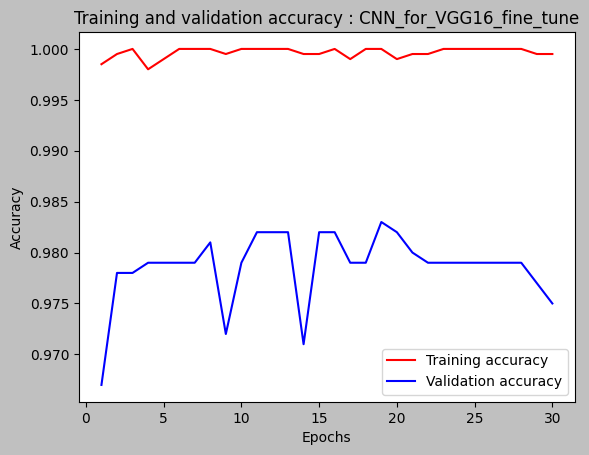

In [ ]:
import matplotlib.pyplot as plt

acc = history_for_VGG16_fine_tune.history["accuracy"]
val_acc = history_for_VGG16_fine_tune.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : CNN_for_VGG16_fine_tune")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.9984999895095825, 0.9994999766349792, 1.0, 0.9980000257492065, 0.9990000128746033, 1.0, 1.0, 1.0, 0.9994999766349792, 1.0, 1.0, 1.0, 1.0, 0.9994999766349792, 0.9994999766349792, 1.0, 0.9990000128746033, 1.0, 1.0, 0.9990000128746033, 0.9994999766349792, 0.9994999766349792, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994999766349792, 0.9994999766349792]
[0.9670000076293945, 0.9779999852180481, 0.9779999852180481, 0.9789999723434448, 0.9789999723434448, 0.9789999723434448, 0.9789999723434448, 0.9810000061988831, 0.972000002861023, 0.9789999723434448, 0.9819999933242798, 0.9819999933242798, 0.9819999933242798, 0.9710000157356262, 0.9819999933242798, 0.9819999933242798, 0.9789999723434448, 0.9789999723434448, 0.9829999804496765, 0.9819999933242798, 0.9800000190734863, 0.9789999723434448, 0.9789999723434448, 0.9789999723434448, 0.9789999723434448, 0.9789999723434448, 0.9789999723434448, 0.9789999723434448, 0.9769999980926514, 0.9750000238418579]


# 繪製折線圖 - Feature Extraction by Different Method

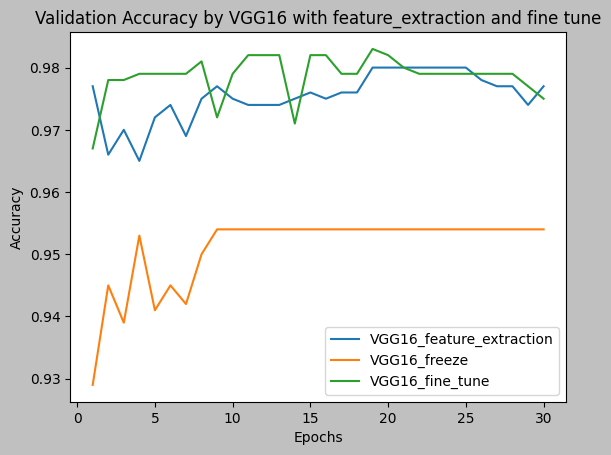

In [ ]:
import matplotlib.pyplot as plt

val_acc_VGG16_feature_extraction = history_for_VGG16_feature_extraction.history["val_accuracy"]
val_acc_VGG16_freeze = history_for_VGG16_freeze.history["val_accuracy"]
val_acc_VGG16_fine_tune = history_for_VGG16_fine_tune.history["val_accuracy"]

epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, val_acc_VGG16_feature_extraction, label="VGG16_feature_extraction")
plt.plot(epochs, val_acc_VGG16_freeze,  label="VGG16_freeze")
plt.plot(epochs, val_acc_VGG16_fine_tune,  label="VGG16_fine_tune")

plt.title("Validation Accuracy by VGG16 with feature_extraction and fine tune")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()